*Think Linear Algebra* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# Truss in the System

In this chapter, we'll use systems of linear equations to analyze trusses.

A **truss** is an assembly of bars connected by joints, usually designed to support a load. Many bridges and roofs are supported by trusses, and if you've ever participated in a model bridge competition, the structure you built was probably a truss.

This picture shows a **Warren truss**, the basis of many railroad bridge designs:

<img width="400" src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/VIEW_OF_BRIDGE_FROM_SOUTH_WITH_ONCOMING_CSX_LOCOMOTIVE_ON_TRACKS_BELOW%2C_LOOKING_NORTHEAST_-_Wills_Creek_Bollman_Bridge%2C_Spanning_CSX_tracks_at_T381%2C_Meyersdale%2C_Somerset_County%2C_HAER_PA%2C56-MEYER.V%2C2-2.tif/lossy-page1-800px-thumbnail.tif.jpg">

This structure is made of three connected triangles with horizontal bars across the top.
It's supported by anchor points at each end, and it carries a deck that supports a roadway.
The load on the truss includes the weight of the roadway, any vehicles on it, and the weight of the truss itself.

To model a structure like this, we'll make some simplifying assumptions:

- We'll treat the structure as two-dimensional, analyzing only one side of the truss.

- We'll assume the joints behave like hinge pins that connect bars at their ends but allow them to rotate freely.

- We'll assume the load is applied only at the joints, not along the length of the bars.

- We'll treat each bar as a spring that pushes or pulls in response to stretching or compression, with force that depends on its size and material.

- We'll assume that the stretching and compression are small enough that the geometry of the truss is unchanged.

These assumptions aren't fully realistic, but they're reasonable approximations.
And they make it easier to analyze the structure -- that is, for a given load, we can compute how much each bar stretches or compresses, and how much force it exerts in response.

The goal is to find an **equilibrium**, where the external forces applied to the truss are balanced by internal spring forces in the bars.

To do this analysis, we'll use **projection matrices**, which we saw in Section XXX, and we'll introduce **block matrices**, which are matrices that contain vectors or submatrices as elements.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkLinearAlgebra/blob/main/nb/truss.ipynb).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkLinearAlgebra/raw/main/utils.py")

In [140]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp

from utils import decorate, gset, gget

## The Simplest Truss

We'll start with a truss that contains two bars, connected at a single joint and supported at two points.

To represent the locations of the joint and the support points, we'll use vectors we'll call `A`, `B`, and `C`.
And to represent the vectors, we'll use a SymPy `Matrix`.
The following function takes two coordinates and returns a symbolic vector.

In [5]:
def sp_vector(x, y):
    return sp.Matrix([x, y])

Here are the positions of the nodes, using the symbol `L` to represent the length of the bars.

In [4]:
L = sp.symbols('L', positive=True)

pos_A = sp_vector(-L, -L)
pos_B = sp_vector(L, -L)   
pos_C = sp_vector(0, 0)

The following diagram shows the configuration of this truss.

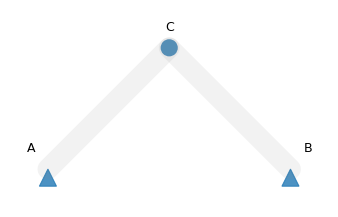

In [7]:
from utils import diagram_truss

subs = {L: 0.15}
nodes = pos_A, pos_B, pos_C
diagram_truss(nodes, subs, lim=0.2)

One bar connects `A` and `C` and the other connects `B` and `C`.
The triangles represent anchors holding the `A` and `B` in place.
The circle represents a pin joint that can move under load.

To start the analysis of this truss, we'll define symbols to represent the displacement of `C` from its starting position due to force applied to it.
These are the unknowns we will solve for.

In [9]:
u_x, u_y = symbols('u_x u_y')

We'll put these symbols in a column vector that represents the displacement of `C`.

In [10]:
u_C = sp_vector(u_x, u_y)
u_C

Matrix([
[u_x],
[u_y]])

Most materials, when they are compressed or stretched by a small amount, are well modeled as a linear spring, where the reaction force is proportional to the size of the displacement.
So we can write $f = k |u|$, where $f$ is the reaction force, $|u|$ is the size of the displacement, and $k$ is the **spring constant**.

For a bar under compression or tension, we can compute $k$ as a function of the size of the bar and its material properties.
Specifically:

$k = \frac{A E}{L}$ 

where $L$ is the length of the bar, $A$ is the cross-sectional area, and `E` is Young's modulus, a constant that quantifies the stiffness of a material -- that is, its ability to push back when compressed or stretched.

The following symbols represent `A` and `E`.
We'll fill in values for these parameters later.

In [11]:
A, E = symbols('A E', positive=True)

Now we can compute the spring constant of the two bars.
To make the analysis more interesting, let's suppose the bar `CB` is twice as thick as `CA`, so it has twice the cross-sectional area.

In [12]:
k_CA = A * E / L
k_CB = 2 * A * E / L

Next we'll compute the spring forces in the truss due to a known displacement.

## Internal Force

Soon we will find the displacement of the truss under a given load.
But first let's suppose, temporarily, that we are given the displacement, `u`.

To compute the spring forces in the bars we have to figure out what part of the displacement, `u`, is along the axis of each bar.
First we'll compute vectors that represent the offset of A and B, relative to C.

In [13]:
r_CA = pos_A - pos_C
r_CB = pos_B - pos_C

Next we'll compute the vector projection of `u` onto `r_CA` and `r_CB`, as shown in this diagram.

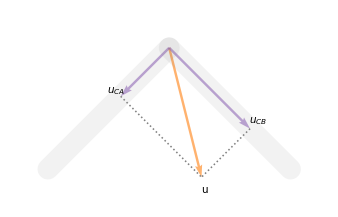

In [145]:
u = sp_vector(2, -8) * 1e-6
scale = 2e4
diagram_truss(nodes, subs, u*scale, lim=0.2, add_pin=False, add_labels=False)

$u_{CA}$ is the component of the displacement in the direction of $r_{CA}$, and
$u_{CB}$ is the component of the displacement in the direction of $r_{CB}$.

To compute these vector projections, we'll use this function, which:

1. Computes the unit vector in the direction of `r`, called `r_hat`,

2. Computes `r_hat.T * u`, which is the scalar magnitude of `u` in the direction of `r_hat`, and

3. Multiplies the result by `r_hat`.

The result is a vector that represents the component of `u` in the direction of `r`. 

In [146]:
def vector_projection(u, r):
    r_hat = r.normalized()
    scalar_projection = r_hat.T * u
    return r_hat * scalar_projection

Now, instead of a known displacement, `u`, suppose we have the unknown displacement `u_C`.
For any value of `u_C`, we can find the spring forces in the bars by computing the vector projections of the displacement onto the axis of the bars, and multiplying by the spring constants.

In [147]:
f_CA = -k_CA * vector_projection(u_C, r_CA)
f_CB = -k_CB * vector_projection(u_C, r_CB)

Here's one of the results, `f_CA`, with the constants factored out.
We'll use `factor_matrix` throughout this chapter to make matrices easier to read by pulling out common factors.

In [148]:
from utils import factor_matrix

factor = -A * E / L / 2
factor_matrix(f_CA, factor)

(-A*E/(2*L))*Matrix([
[u_x + u_y],
[u_x + u_y]])

`f_CA` is a column vector that represents the reaction force of bar `CA` if `C` is displaced by `u_C`; similarly `f_CB` represents the reaction force of bar `CB`.

The total force at `C` due to this displacement, which we'll call the **internal force**, is the sum of the reaction forces.

In [149]:
f_int = f_CA + f_CB

Now let's find the displacement of the truss under load.

## Equilibrium

Suppose we apply a force at `C` that pulls down in the `y` direction, with no additional force in the `x` direction.
We can represent this **external force** with the following vector, where the `F` represents the magnitude of the force.

In [150]:
F = symbols('F')
f_ext = sp_vector(0, -F)

If the truss is not moving, the internal and external forces must add up to zero, so we can write the equation $f_{int} = -f_{ext}$.

In [151]:
eq = sp.Eq(f_int, -f_ext)

Which we can display concisely like this.

In [152]:
sp.Eq(factor_matrix(f_int, factor), -f_ext)

Eq((-A*E/(2*L))*Matrix([
[ 3*u_x - u_y],
[-u_x + 3*u_y]]), Matrix([
[0],
[F]]))

To analyze the truss, we want to find the displacement `u_C` that solves this equation.
First, let's plug in values for the symbols, assuming that the truss is made of wooden popsicle sticks.

A common popsicle stick is about 15 cm long, 1 cm wide, and 0.2 cm thick.
The Young's modulus of wood is about 3 gigapascal.
Let's suppose the external force is the weight of a one kilogram mass, which is roughly 9.8 N.
We'll use the `pint` library to represent these quantities, including their units.

In [153]:
import pint
ureg = pint.UnitRegistry()

params = {
    L: 15.0 * ureg.cm,
    E: 3.0e9 * ureg.Pa,
    A: 1.0 * ureg.cm * 0.2 * ureg.cm,
    F: 9.8 * ureg.newton,
}

To substitute these values into the equation, we'll use this function, which makes a dictionary that maps from symbols to their values, converted to base units.
For example, `L` in centimeters gets converted to meters, and `A` to square meters.

In [154]:
def make_subs(params):
    """Make a dictionary that maps from symbols to quantities."""
    return {symbol: param.to_base_units().magnitude 
            for symbol, param in params.items()}

Here are the results in SI units.

In [155]:
subs = make_subs(params)
subs

{L: 0.15, E: 3000000000.0, A: 2e-05, F: 9.8}

Now we'll use the `subs` method to replace the symbols in the equation with these numbers.

In [156]:
eq_num = eq.subs(subs).simplify()
eq_num

Eq(Matrix([
[  0],
[9.8]]), Matrix([
[-600000.0*u_x + 200000.0*u_y],
[ 200000.0*u_x - 600000.0*u_y]]))

And `solve` to find the value of `u_C`.

In [157]:
sol = sp.solve(eq_num, u_C)
sol

{u_x: -6.12500000000000e-6, u_y: -1.83750000000000e-5}

The result is a dictionary that maps from the unknown components to their values.
To put these values in a vector, we can use `subs` again, and display the result in micrometers.

In [158]:
u_sol = u_C.subs(sol)
sp.Eq(u_C, u_sol * 1e6)

Eq(Matrix([
[u_x],
[u_y]]), Matrix([
[ -6.125],
[-18.375]]))

So if we hang a 1 kg mass from a truss like this made of popsicle sticks, we expect `C` to be displaced by about 6 micrometers left and 18 micrometers down.

To see whether this result is plausible, let's compare it with the result from a simpler configuration.
If we balance a 1 kg mass on top of a vertical popsicle stick, and hold the bottom fixed, we can compute the displacement like this.

In [29]:
displacement = F * L / A / E
displacement.subs(subs) * 1e6

24.5000000000000

The displacement we calculated for the simple truss is a little smaller than the displacement we expect from a single popsicle stick, so the results of the analysis seem plausible.

The simple truss is made of three popsicle sticks (remember that we doubled the thickness of `CB`), so we might expect it to be three times stiffer.
But the bars are diagonal, so only part of the displacement is along the axis of each bar, and only part of the reaction force is in the vertical direction.

Before we leave this example, let's also remember that our model of the truss is based on the assumption that the displacements are small enough that the bars are not deformed or broken.
With a 1 kilogram mass, the displacements we computed are much smaller than the lengths of the bars, so that assumption seems reasonable.

In contrast, suppose we use the same method to compute the displacement due to a 1000 kg mass.
The result would be about 0.6 cm left and 1.8 cm down.
If you are familiar with popsicle sticks, you probably have a sense that it is not possible to stretch or compress one by more than a centimeter without breaking it.
So the model we used to analyze this truss would not be realistic for such a large external force.

In [32]:
sp.Matrix([0.6, 1.8]).norm()

1.89736659610103

We're almost ready to take on a more complex truss, but first we need a new tool, the stiffness matrix.

## The Stiffness Matrix

In the previous section, we wrote this equation with internal force on the left and external force on the right:

In [33]:
sp.Eq(factor_matrix(f_int, factor), -f_ext)

Eq((-A*E/(2*L))*Matrix([
[ 3*u_x - u_y],
[-u_x + 3*u_y]]), Matrix([
[0],
[F]]))

That was sufficient to analyze the simple truss, but for more complex trusses, we need a more general method.
Specifically, we'll write a matrix equation $K u = f$, where $u$ is the vector of unknown displacements, $f$ is the vector of external forces, and $K$ is the **stiffness matrix** that represents the relationship between the displacements and the reaction forces.

As an example, we'll rewrite the equation from the previous section in this form.
To start, let's rethink the scalar projection.

$$\mathrm{proj}_{r} u = \hat{r}\, \hat{r}^T u$$

In `vector_projection`, we computed the scalar projection $\hat{r}^T u$ first, to get the magnitude of the projection of $u$ in the direction of $r$, and then multiplied by $\hat{r}$.
In other words, we evaluated the vector projection like this:

$$\mathrm{proj}_{r} u = \hat{r}\, (\hat{r}^T u)$$

As an alternative, we could have multiplied $\hat{r}$ and $\hat{r}^T$ first, like this:

$$\mathrm{proj}_{r} u = (\hat{r}\, \hat{r}^T) u$$

The product $\hat{r}\, \hat{r}^T$ is a **projector matrix**, which we can compute like this.

In [34]:
def projector(r):
    rhat = r.normalized()
    return rhat * rhat.T

As an example, here's the projector matrix for the vector `r_CA`.

In [161]:
P_CA = projector(r_CA)
P_CA

Matrix([
[1/2, 1/2],
[1/2, 1/2]])

Now if we multiply `P_CA` and `u_C`, the result is the vector projection of `u_C` onto `r_CA`.

In [162]:
P_CA * u_C

Matrix([
[u_x/2 + u_y/2],
[u_x/2 + u_y/2]])

If we multiply a projector matrix by the spring constant `k`, the result is a the stiffness matrix.
So `k_CA * P_CA` is the stiffness matrix due to bar `CA`, and `k_CB * P_CB` is the stiffness matrix due to bar `CB`.
Their sum is the stiffness matrix for the whole truss, which we'll call `K`.

In [38]:
P_CB = projector(r_CB)

K = k_CA * P_CA + k_CB * P_CB
factor_matrix(K, A * E / L / 2)

(A*E/(2*L))*Matrix([
[ 3, -1],
[-1,  3]])

If we multiply `K` by a displacement vector, the result is a force vector that represents the internal force due to that displacement.
So we can interpret the stiffness matrix by testing it with small displacements.
First we'll use `subs` to replace the symbols in `K` with numbers.

In [39]:
from utils import sympy_to_numpy

K_np = sympy_to_numpy(K, subs)
K_np

array([[ 600000., -200000.],
       [-200000.,  600000.]])

Here's an example where we displace node `C` by one micrometer in the `x` direction.

In [40]:
u_example1 = np.array([1, 0]) * 1e-6
f_example1 = -K_np @ u_example1
f_example1

array([-0.6,  0.2])

The restoring force is 0.6 N in the negative `x` direction and 0.2 N in the positive `y` direction.
And here's an example where we displace `C` by one micrometer in the `y` direction.

In [41]:
u_example2 = np.array([0, 1]) * 1e-6
f_example2 = -K_np @ u_example2
f_example2

array([ 0.2, -0.6])

The restoring force is about 0.2 N in the positive `x` direction and 0.6 N in the negative `y` direction.

More generally, we can use `K` to compute the force that results from any displacement.
To demonstrate, we'll make an array of 9 values from -20 to 20 micrometers.

In [42]:
scale = 1e-6
bound = 20
displacements = np.linspace(-bound, bound, 9) * scale

By enumerating all pairs of values, we can make an array of 81 displacement vectors.

In [43]:
pairs = [(x, y) for x in displacements for y in displacements]
U = np.array(pairs).T 
U.shape

(2, 81)

`U` is matrix-like in the sense that it has two dimensions, but we are using it as a collection of vectors, not a matrix.
If we multiply by the stiffness matrix, the result is a collection of force vectors.

In [44]:
F_field = -K_np @ U
F_field.shape

(2, 81)

The following figure shows these results.
The location of each arrow shows a hypothetical displacement.
Each arrow shows the direction and relative magnitude of the resulting force due to displacement.
Note that the positions and forces are not in the same units, so the scale of the arrows is arbitrary.

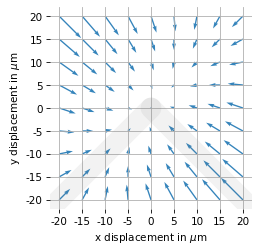

In [45]:
from utils import plot_force_field
    
ticks = np.arange(-20, 21, 5)
lim = scale * (bound + 2)
plot_force_field(nodes, subs, F_field, U, lim, displacements, ticks)

Notice that the restoring forces are bigger in the upper left and lower right, which correspond to extension and compression of the thicker bar.

In summary, multiplication by `K` is like a function that takes a displacement vector and returns a corresponding force vector.
A function that maps vectors to other vectors is sometimes called a **vector field**.
And when those vectors represent forces, we call it a **force field**.

Finally, let's confirm that we get the same result using NumPy to solve $K u = f$.
First we'll convert the external force vector to an array.

In [46]:
f_ext_np = sympy_to_numpy(f_ext, subs)
f_ext_np

array([ 0. , -9.8])

And here's the solution.

In [47]:
import scipy

scipy.linalg.solve(K_np, f_ext_np) * 1e6

array([ -6.125, -18.375])

That's the same as the result we got before we factored out the stiffness matrix.

The key idea of this example is the use of the projector matrix to construct the stiffness matrix.
We'll use this idea again in the next example.

## Warren Trusses

So far we've been working with a simple truss with two bars and only one joint that can move, so we wrote a vector equation with only two components.
Now let's try something a little harder -- we'll analyze a Warren truss.
We'll use NetworkX to represent the joints and bars as nodes and edges; then we'll construct a matrix equation that relates the displacements at the joints to the external forces.

To specify the structure of the truss, we'll define `N`, which is the number of triangles, `L`, which is the length of the bars, and `H`, which is the height of the triangles.
If the bars are all the same length, the triangles are equilateral, so $H = \frac{\sqrt{3} L}{2}$.

In [139]:
N = 2
L = sp.Symbol('L', positive=True)
H = sp.sqrt(3) * L / 2

Now let's make the graph.
To understand the code in this section, you might find it helpful to look ahead to the diagram that shows the results.

In [49]:
G = nx.Graph()

First we'll create the nodes that run along the bottom of the truss and the edges that connect them.

In [50]:
origin = sp_vector(0, 0)

for i in range(N + 1):
    pos = origin + sp_vector(i * L, 0)
    G.add_node(f'B{i}', pos=pos)
    if i > 0:
        G.add_edge(f'B{i-1}', f'B{i}')

The bottom nodes are assigned positions based on `L`, and labeled with strings like `B0`, `B1`, etc.

Now we'll add the nodes that run along the top, the horizontal edges that connect them, and the diagonal edges that connect the top and bottom nodes.

In [51]:
for i in range(N):
    pos = origin + sp_vector((i + sp.Rational(1, 2)) * L, H)
    G.add_node(f'T{i}', pos=pos)
    G.add_edge(f'B{i}', f'T{i}')
    G.add_edge(f'T{i}', f'B{i+1}')

    if i > 0:
        G.add_edge(f'T{i-1}', f'T{i}')

The top nodes are assigned positions based on `L` and `H`, and labeled `T0`, `T1`, etc.
Here's what the graph looks like.

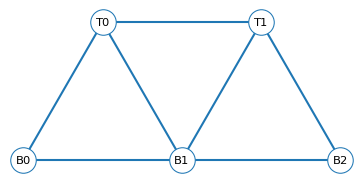

In [52]:
from utils import draw_truss_graph

draw_truss_graph(G, {L: 0.15})

For reasons we'll see later, it will be convenient if every node has a unique index starting from `0`.
So we'll loop through the nodes and use `gset` to assign each node an index.

In [53]:
for i, node in enumerate(G.nodes):
    gset(G, node, index=i)

Now we'll loop through the nodes and assign a displacement vector to each one.

In [54]:
for node in G.nodes():
    ux, uy = sp.symbols(f'u_{node}_x u_{node}_y')    
    disp = sp_vector(ux, uy)
    gset(G, node, disp=disp)

For this example, we'll assume that the roadway is attached to the bottom nodes.
To keep things simple, we'll ignore the weight of the truss itself and assume that the load is attached to a single node, `B1`.
The following loop creates a force vector for each node in the truss and assigns it to an attribute called `f_ext`.

In [100]:
F = sp.Symbol('F')
weighted = ['B1']

for node in G.nodes:
    if node in weighted:
        gset(G, node, f_ext=sp_vector(0, -F))
    else:
        gset(G, node, f_ext=sp_vector(0, 0))

Finally, for each bar, we'll compute a projector matrix that computes the projection of a displacement vector along the axis of the bar.

In [101]:
for edge in G.edges:
    node1, node2 = edge
    x1 = G.nodes[node1]['pos']
    x2 = G.nodes[node2]['pos']
    r = x2 - x1
    P = projector(r)
    gset(G, edge, P=P)

To keep this example simple, we'll assume that every bar has the same cross-sectional area and Young's modulus.
But it would be easy to generalize by adding these attributes to the edges.

## Block Matrix Equation

At this point we have a NetworkX graph that represents the bars and joints of the truss.
The next step is to write a matrix equation to relate the unknown displacements to the internal and external forces.
To do that, we will construct a **block matrix** which is a way to represent a system of equations where the unknowns are vectors.

To show the structure of the problem, we'll construct with a vector of displacements, where each displacement is itself a vector.

In [102]:
blocks = [sp.MatrixSymbol(f'u_{{{node}}}', 2, 1) for node in G.nodes]
u_block = sp.BlockMatrix([[u] for u in blocks])

Matrix([
[u_{B0}],
[u_{B1}],
[u_{B2}],
[u_{T0}],
[u_{T1}]])

And another vector that represents the external forces on the nodes.

In [103]:
blocks = [sp.MatrixSymbol(f'f_{{{node}}}', 2, 1) for node in G.nodes]
f_block = sp.BlockMatrix([[f] for f in blocks])

Matrix([
[f_{B0}],
[f_{B1}],
[f_{B2}],
[f_{T0}],
[f_{T1}]])

Now we'll create a block matrix where each element is a stiffness matrix -- the element $K_{ij}$ represents the stiffness at node $i$ due to its connection to node $j$.

In [104]:
def Ksym(i, j):
    return sp.MatrixSymbol(f'K_{i}{j}', 2, 2)

In [105]:
n = len(G.nodes)
blocks = [[Ksym(i, j) for j in range(n)] for i in range(n)]
K_block = sp.BlockMatrix(blocks)

Matrix([
[K_00, K_01, K_02, K_03, K_04],
[K_10, K_11, K_12, K_13, K_14],
[K_20, K_21, K_22, K_23, K_24],
[K_30, K_31, K_32, K_33, K_34],
[K_40, K_41, K_42, K_43, K_44]])

Here's the equation that relates the block matrices.

In [106]:
equation = sp.Eq(K_block * u_block, f_block)
equation

Eq(Matrix([
[K_00, K_01, K_02, K_03, K_04],
[K_10, K_11, K_12, K_13, K_14],
[K_20, K_21, K_22, K_23, K_24],
[K_30, K_31, K_32, K_33, K_34],
[K_40, K_41, K_42, K_43, K_44]])*Matrix([
[u_{B0}],
[u_{B1}],
[u_{B2}],
[u_{T0}],
[u_{T1}]]), Matrix([
[f_{B0}],
[f_{B1}],
[f_{B2}],
[f_{T0}],
[f_{T1}]]))

Let's think about what each element of the stiffness matrix means.
Each row represents an equation that computes the sum of the internal forces on one node, given the displacements of all of the nodes.
And each column represents the contribution of one displacement to the internal forces on all of the nodes.

Now let's think about how to compute the elements of $K$.
As an example, consider the edge between `B0` and `T0`, which are nodes 0 and 2.
The stiffness matrix of that edge contributes to four elements of $K$:

* In row 0, it contributes to $K_{00}$ and $K_{03}$, because the internal force on node 0 depends on the difference of displacements $u_{B0}$ and $u_{T0}$.

* In row 3, it contributes to $K_{30}$ and $K_{33}$, because the internal force on node 3 depends on the same difference of displacements.

In the next section, we'll assemble $K$ by looping through the edges and adding up the contributions from the stiffness matrix of each bar.

## Compute the Block Matrix

To construct the block matrix, we'll loop through the edges and compute a matrix that represents the stiffness of each node due to the other nodes it is connected to.
We'll start by working through a single example, the edge from `B0` to `T0`.
We can use `gget` to get the projector matrix for this edge.

In [107]:
edge = 'B0', 'T0'
P = gget(G, edge, "P")
P

Matrix([
[      1/4, sqrt(3)/4],
[sqrt(3)/4,       3/4]])

Next we'll get the displacements of the nodes.

In [108]:
node1, node2 = edge
u1 = gget(G, node1, "disp")
u2 = gget(G, node2, "disp")

If both ends of the bar are displaced, the total extension or compression is the difference between the displacements, `u1 - u2`.
So we can compute the stiffness matrix for a single bar like this.

In [109]:
k = A * E / L
kP = -k * P
factor_matrix(kP, k/4)

(A*E/(4*L))*Matrix([
[      -1, -sqrt(3)],
[-sqrt(3),       -3]])

Now we're ready to assemble the block matrix.
We'll start with a list of lists, where each element is a stiffness matrix full of zeroes.
As we loop through the edges, we'll add to these matrices.

In [110]:
blocks = [[sp.Matrix.zeros(2, 2) for _ in range(n)] for _ in range(n)]

Now here's the key to the whole operation.
If `kP` is the stiffness matrix of the bar that connects `u1` and `u2`, the internal force in that bar is `kP * (u1 - u2)`, which we can factor as `kP * u1` and `-kP * u2`.

Now let's figure out how to add `kP` to the block matrix.
Remember that each row of the block matrix represents an equation that computes the total internal force on that node.
And each column represents the contribution of one displacement to each of the nodes.

So each edge contributes to two rows in the matrix, one for each node it connects.
And it contributes to two columns, because it depends on the difference between two displacements.

To break this down, we'll use the following function, which takes two nodes and a stiffness matrix, `kP`.
It uses `gget` to look up the indices of the nodes.
Then it modifies two blocks in the row corresponding to `u1`: it adds `kP` to the column corresponding to `u1` and subtracts `kP` from the column corresponding to `u2`.
These changes represent the stiffness at `node1` because it is connected to `node2`.

In [111]:
def add_block(node1, node2, kP):
    i = gget(G, node1, 'index')
    j = gget(G, node2, 'index')
    
    blocks[i][i] +=  kP
    blocks[i][j] += -kP

Now for each edge in the graph, we call `add_block` twice, once to add the stiffness at `node1` because it is connected to `node2`, and once to add the stiffness at `node2` because it is connected with `node1`.

In [112]:
for edge in G.edges:
    node1, node2 = edge
    P = gget(G, edge, "P")

    add_block(node1, node2, k * P)
    add_block(node2, node1, k * P)

The result is a list of lists of matrices, each the sum of some number of stiffness matrices.
Finally, we can use the list of lists to make a `BlockMatrix`.
Here's the result, shown with the common factor $k/4$ pulled out.

In [113]:
K_block = sp.BlockMatrix(blocks)
factor_matrix(K_block, factor=k/4)

(A*E/(4*L))*Matrix([
[    Matrix([
[      5, sqrt(3)],
[sqrt(3),       3]]),                           Matrix([
[-4, 0],
[ 0, 0]]),                             Matrix([
[0, 0],
[0, 0]]), Matrix([
[      -1, -sqrt(3)],
[-sqrt(3),       -3]]),                             Matrix([
[0, 0],
[0, 0]])],
[                          Matrix([
[-4, 0],
[ 0, 0]]),                           Matrix([
[10, 0],
[ 0, 6]]),                           Matrix([
[-4, 0],
[ 0, 0]]),     Matrix([
[     -1, sqrt(3)],
[sqrt(3),      -3]]), Matrix([
[      -1, -sqrt(3)],
[-sqrt(3),       -3]])],
[                            Matrix([
[0, 0],
[0, 0]]),                           Matrix([
[-4, 0],
[ 0, 0]]), Matrix([
[       5, -sqrt(3)],
[-sqrt(3),        3]]),                             Matrix([
[0, 0],
[0, 0]]),     Matrix([
[     -1, sqrt(3)],
[sqrt(3),      -3]])],
[Matrix([
[      -1, -sqrt(3)],
[-sqrt(3),       -3]]),     Matrix([
[     -1, sqrt(3)],
[sqrt(3),      -3]]),                             Matrix([


Now let's see if we can solve the matrix equation $K u = f$ (hint: we can't quite yet).

## Shift and Rotate

At this point we have a block matrix with five columns -- one for each displacement -- and five rows -- one for each equation.
So if we are given five external forces, it's tempting to think we can solve for the unknown displacements.
But we can't, because the stiffness matrix we assembled does not have full rank.

Before we can compute its rank, we have to convert `k_block` from a 5x5 block matrix to a 10x10 conventional matrix, using the method `as_explicit`.

In [114]:
K = K_block.as_explicit()
factor_matrix(K, k/4)

(A*E/(4*L))*Matrix([
[       5,  sqrt(3),       -4,        0,        0,        0,       -1, -sqrt(3),        0,        0],
[ sqrt(3),        3,        0,        0,        0,        0, -sqrt(3),       -3,        0,        0],
[      -4,        0,       10,        0,       -4,        0,       -1,  sqrt(3),       -1, -sqrt(3)],
[       0,        0,        0,        6,        0,        0,  sqrt(3),       -3, -sqrt(3),       -3],
[       0,        0,       -4,        0,        5, -sqrt(3),        0,        0,       -1,  sqrt(3)],
[       0,        0,        0,        0, -sqrt(3),        3,        0,        0,  sqrt(3),       -3],
[      -1, -sqrt(3),       -1,  sqrt(3),        0,        0,        6,        0,       -4,        0],
[-sqrt(3),       -3,  sqrt(3),       -3,        0,        0,        0,        6,        0,        0],
[       0,        0,       -1, -sqrt(3),       -1,  sqrt(3),       -4,        0,        6,        0],
[       0,        0, -sqrt(3),       -3,  sqrt(3),       -3, 

Now we can compute the rank, which indicates the number of non-redundant equations it represents.

In [115]:
K.rank()

7

Although the matrix has 10 rows, the rank is only 7, which means that the matrix represents only 7 independent equations.
The rank-nullity theorem implies that it has a three-dimensional nullspace, which we can compute with the `nullspace` method.

In [116]:
nullspace = K.nullspace()
len(nullspace)

3

The result is a list of three vectors.
Each of them is a solution to the homogeneous equation $K u = 0$, which means that there are three ways we can displace the truss that don't depend on the external forces.

If you think about the physical scenario we are modeling, you might be able to figure out what they are.
The equations we have written so far balance the internal and external forces, but they don't constrain the truss from moving in space.
Because the truss is not attached to anything, it is free to shift in the `x` direction, shift in the `y` direction, and rotate.
These unconstrained ways of moving are called **degrees of freedom**.

If we inspect the vectors in the nullspace, we can see how they correspond to these degress of freedom.
We'll use this function to extract the displacements of the nodes, in symbolic form, and put them in a block matrix.

In [117]:
def get_block_vector(G, attr, keep=None):
    blocks = [gget(G, node, attr) for node in G.nodes]
    if keep is not None:
        blocks = [blocks[i] for i in keep]
    return sp.BlockMatrix([[block] for block in blocks])

In [118]:
u_sym = get_block_vector(G, 'disp').as_explicit()

Now here's the second of the three null vectors, which is the easiest to interpret.

In [119]:
v_null_1 = nullspace[1]
sp.Eq(u_sym, v_null_1)

Eq(Matrix([
[u_B0_x],
[u_B0_y],
[u_B1_x],
[u_B1_y],
[u_B2_x],
[u_B2_y],
[u_T0_x],
[u_T0_y],
[u_T1_x],
[u_T1_y]]), Matrix([
[1],
[0],
[1],
[0],
[1],
[0],
[1],
[0],
[1],
[0]]))

This vector represents a displacement of all nodes by one unit in the `x` direction.

The sum of the other two null vectors is similar -- it displaces all nodes by one unit in the `y` direction.

In [120]:
v_null_2 = (nullspace[0] + nullspace[2])
sp.Eq(u_sym, v_null_2)

Eq(Matrix([
[u_B0_x],
[u_B0_y],
[u_B1_x],
[u_B1_y],
[u_B2_x],
[u_B2_y],
[u_T0_x],
[u_T0_y],
[u_T1_x],
[u_T1_y]]), Matrix([
[0],
[1],
[0],
[1],
[0],
[1],
[0],
[1],
[0],
[1]]))

Finally, here's the difference between the same two null vectors.

In [121]:
v_null_3 = (nullspace[0] - nullspace[2])
sp.Eq(u_sym, v_null_3)

Eq(Matrix([
[u_B0_x],
[u_B0_y],
[u_B1_x],
[u_B1_y],
[u_B2_x],
[u_B2_y],
[u_T0_x],
[u_T0_y],
[u_T1_x],
[u_T1_y]]), Matrix([
[-sqrt(3)],
[       2],
[-sqrt(3)],
[       0],
[-sqrt(3)],
[      -2],
[       0],
[       1],
[       0],
[      -1]]))

Looking at the components of this vector, it's not obvious what it means.
It will be clearer if we plot the effect it has on the truss.
To do that, we'll pack it into a dictionary that maps from the components of the displacement vectors to the elements of the null vector.

In [122]:
rotation = dict(zip(u_sym, v_null_3))

We'll use the following function to loop through the nodes in the graph and displace each node using the values in this dictionary.

In [123]:
def displace_truss(G, sol, scale=300):
    G_sol = G.copy()

    for node in G_sol.nodes:
        pos = gget(G_sol, node, 'pos')
        u = gget(G_sol, node, 'disp')
        u_eval = u.subs(sol).evalf() * scale 
        gset(G_sol, node, pos=pos + u_eval)

    return G_sol

The `scale` parameter determines the magnitudes of the displacements.

In [124]:
G_rot = displace_truss(G, rotation, scale=0.005)

Finally, let's draw the displaced truss on top of an outline of the original.

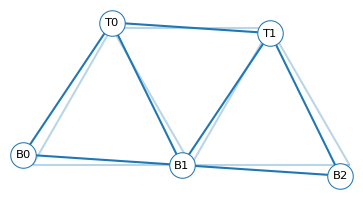

In [125]:
draw_truss_graph(G, subs, label_nodes=False, alpha=0.3)
draw_truss_graph(G_rot, subs)

Now we can see that this null vector represents the third degree of freedom, rotation.

With 10 unknowns and only 7 independent equations, this system is **underdetermined**, which means it has many possible solutions.
But that's because we have not yet taken into account all of the information we have about the physical scenario -- specifically, we know that two of the nodes are fixed in space.

## Reduce the Matrix

Let's assume that the truss is attached firmly at the left and right.
The following loop makes a copy of the graph where the displacement at those nodes is zero.

In [126]:
fixed_nodes = ['B0', f'B{N}']
G_fixed = G.copy()

for node in G.nodes():
    if node in fixed_nodes:
        disp = sp_vector(0, 0)
        gset(G_fixed, node, disp=disp)

Since these displacements are no longer unknown, we can remove them from the matrix equation.
First, we'll compute the indices of the remaining nodes that are not fixed.

In [127]:
keep = [gget(G_fixed, node, 'index') 
        for node in G_fixed.nodes 
        if node not in fixed_nodes]
keep    

[1, 3, 4]

Now we'll select the blocks that correspond to these nodes.

In [128]:
blocks_reduced = [
    [blocks[i][j] 
     for j in keep]
     for i in keep
]

And make a new block matrix that has been **reduced** by removing the known displacements.

In [129]:
K_reduced = sp.BlockMatrix(blocks_reduced)
factor_matrix(K_reduced, k/4)

(A*E/(4*L))*Matrix([
[                          Matrix([
[10, 0],
[ 0, 6]]), Matrix([
[     -1, sqrt(3)],
[sqrt(3),      -3]]), Matrix([
[      -1, -sqrt(3)],
[-sqrt(3),       -3]])],
[    Matrix([
[     -1, sqrt(3)],
[sqrt(3),      -3]]),                         Matrix([
[6, 0],
[0, 6]]),                           Matrix([
[-4, 0],
[ 0, 0]])],
[Matrix([
[      -1, -sqrt(3)],
[-sqrt(3),       -3]]),                       Matrix([
[-4, 0],
[ 0, 0]]),                             Matrix([
[6, 0],
[0, 6]])]])

Now there are only 6 columns, and the matrix has **full rank** -- that is, the equations it represents are independent. 

In [130]:
K_reduced.as_explicit().rank()

6

And that means the equation $K u = f$ has a unique solution for any vector of forces, $f$. 

To solve the system, we'll use `get_block_vector` to loop through the graph and collect the unknown displacements.

In [131]:
u_reduced = get_block_vector(G_fixed, 'disp', keep)
u_reduced

Matrix([
[Matrix([
[u_B1_x],
[u_B1_y]])],
[Matrix([
[u_T0_x],
[u_T0_y]])],
[Matrix([
[u_T1_x],
[u_T1_y]])]])

And we can collect the external forces the same way.

In [132]:
f_reduced = get_block_vector(G_fixed, 'f_ext', keep)
f_reduced

Matrix([
[      Matrix([
[0],
[0]])],
[Matrix([
[   0],
[-F/2]])],
[Matrix([
[   0],
[-F/2]])]])

Now (finally!) we are ready to solve the system.

## Solve the System

Here's the matrix equation, $K u = f$.

In [133]:
eq = sp.Eq(K_reduced * u_reduced, f_reduced)

We can use `subs` again to replace the symbols with their values.

In [134]:
eq_num = eq.subs(subs)

The result is a numerical matrix equation we can solve for the unknown displacements.

In [135]:
sol = sp.solve(eq_num, u_reduced.as_explicit())

Here's what the result looks like.

In [136]:
u_sol = u_reduced.subs(sol)
sp.Eq(u_reduced, factor_matrix(u_sol, 1e-6))

Eq(Matrix([
[Matrix([
[u_B1_x],
[u_B1_y]])],
[Matrix([
[u_T0_x],
[u_T0_y]])],
[Matrix([
[u_T1_x],
[u_T1_y]])]]), 1.0e-6*Matrix([
[Matrix([
[                0],
[-20.4166666666667]])],
[  Matrix([
[3.53627039878646],
[         -18.375]])],
[Matrix([
[-3.53627039878646],
[          -18.375]])]]))

And here's what those displacements look like, scaled up by a factor of 300 to make them visible.

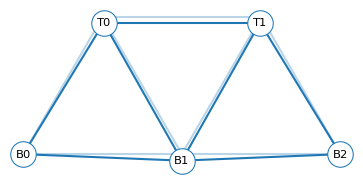

In [137]:
G_sol = displace_truss(G_fixed, sol, scale=300)

draw_truss_graph(G, subs, label_nodes=False, alpha=0.3)
draw_truss_graph(G_sol, subs)

At `B1`, the displacement in the `y` direction is about 41 micrometers, which is about twice the displacement we computed for the simple truss.
And that makes sense because the span of this truss is about twice the span of the simple truss.

If you go back where we defined `N = 2`, you can set `N` to another value and run the notebook again.
See what happens to the results as you increase `N`.

In some Warren trusses, the roadbed is suspended from the top nodes, rather than attached to the bottom nodes.
Run the analysis with half of the load on each of `T0` and `T1`, rather than all of it on `B0`.
Are the displacements bigger or smaller?

TECHNICAL NOTE: If you've seen truss analysis before, you might have been surprised that I constrained the fixed nodes in both dimensions.
In textbook truss analysis, it is more common to constrain one of the nodes in only one dimension.
In this example, that would reduce the 10x10 underdetermined system to a 7x7 fully determined system.
By fixing two nodes entirely, we reduced it to a 6x6 system, also fully determined.

The conventional approach imposes the minimal number of constraints, but the approach I used here was a little easier to implement, and I think it's a more realistic model of a real bridge, where the two endpoints are generally similar.
But either method is fine.

## Discussion

When I was an undergraduate, I took a class where we learned to analyze trusses.
One of my classmates asked a question that I'm not sure I appreciated at the time, but it stuck with me.
To paraphrase, he asked, "Do we design trusses because they are optimal, or because they are easy to analyze?"
This is a really good question.

As you might guess, the answer is both.
If your goal is to build a structure that supports a given load with a minimum amount of material, a truss may not be optimal -- with the complexity of real-world requirements and constraints, it's hard to say what "optimal" even means.
But for many applications, a truss is a fundamentally good design.

It is also easy to analyze, but that is not as important as it used to be.
Before we had computers, we analyzed structures by hand, so we had to keep them simple.
When I was an undergraduate, we had enough computational power and software capability to analyze more complex structures, but what we could design was still limited by what we could analyze.

Now with modern computational tools, we can analyze almost any structure we can imagine, so analysis is no longer the limiting factor on what we can design and build.
But this is a recent change, and we are only beginning to see its consequences.

[Think Linear Algebra](https://allendowney.github.io/ThinkLinearAlgebra/index.html)

Copyright 2025 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)